
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 2

### Integrantes
- Bosch, Daniela
- Gherra, Estefanía
- Iberra, Yanina
- Mantovani, Luciano
- Palacio Pastor, Natalí

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (se debe seleccionar del sistema de archivos local por medio del botón "Choose files" el archivo loan_data.csv). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving loan_data.csv to loan_data.csv


In [3]:
import io
dataset = pd.read_csv(io.StringIO(uploaded['loan_data.csv'].decode('utf-8')), comment="#")
dataset.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [4]:
dataset.shape

(1854, 11)

Veamos la variación de los datos calculando el coeficiente de variación de cada variable.

In [5]:
# Coeficiente de variación
dataset.std()/dataset.mean()

TARGET     2.236671
LOAN       0.575580
MORTDUE    0.605731
VALUE      0.522168
YOJ        0.848595
DEROG      3.755321
DELINQ     2.902783
CLAGE      0.470538
NINQ       1.474480
CLNO       0.435138
DEBTINC    0.269247
dtype: float64

Debido a la variabilidad de los valores que toma cada variable, se deciden escalar los datos usando la estandarización. 

In [6]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# Escalar conjunto de datos
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)
X_train.shape, X_test.shape

((1483, 10), (371, 10))

Veamos cuántos valores hay de cada clase:

In [7]:
y.value_counts()

0    1545
1     309
Name: TARGET, dtype: int64

In [8]:
y.value_counts()[0]/y.value_counts()[1]

5.0

Vemos que existe un desbalanceo de clases de proporción 5 a 1.
- clase 0: 1545 casos.
- clase 1: 309 casos.

Visualizamos las proporciones de cada clase en el conjunto de train y test:

In [9]:
y_train.value_counts()

0    1236
1     247
Name: TARGET, dtype: int64

In [10]:
y_test.value_counts()

0    309
1     62
Name: TARGET, dtype: int64

El desbalanceo de clases se mantiene en los conjuntos de train y test, casi en la misma proporción de 5:1.


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

**1. ¿De qué se trata el conjunto de datos?**

Es un conjunto de datos de préstamos, basado en un set de datos de Kaggle Home Equity.
Disponible en: https://www.kaggle.com/ajay1735/hmeq-data



---


**2.¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?**

El conjunto de datos contiene información de referencia y de rendimiento de los préstamos con garantía hipotecaria. La variable objetivo (TARGET) posee datos binarios, e indica si un solicitante eventualmente incurrió en incumplimiento o fue gravemente moroso.

Etiqueta `TARGET`: 
- 1 = el cliente ha dejado de pagar el préstamo (incumplimiento, gravemente moroso)
- 0 = el préstamo se ha devuelto



---


**3.¿Qué información (atributos) hay disponible para hacer la predicción?**

El dataset cuenta con 10 attributos para la predicción de la variable objetivo:

- **LOAN**: Importe de la solicitud de préstamo.
- **MORTDUE**: Importe adeudado de la hipoteca actual.
- **VALUE**: Valor de la propiedad actual.
- **YOJ**: Años en el trabajo actual.
- **DEROG**: Número de informes derogatorios importantes.
- **DELINQ**: Número de líneas de crédito morosas.
- **CLAGE**: Edad de la línea comercial más antigua en meses.
- **NINQ**: Número de líneas de crédito recientes.
- **CLNO**: Número de líneas de crédito.
- **DEBTINC**: Ratio deuda-ingresos.



---


**4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?**

Consideramos que pueden ser importantes para la predicción de que si un cliente cancelará un préstamo o no, todas las variables relacionadas a deudas además del monto del pŕestamos solicitado:

- LOAN
- DEBTINC
- MORTDUE
- DELINQ
- CLNO
- NINQ

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión

In [11]:
# Instanciar y entrenar.
sgd = SGDClassifier(random_state=0)
sgd.fit(X_train, y_train) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# Predecir
y_train_pred = sgd.predict(X_train)
y_test_pred = sgd.predict(X_test)

In [13]:
# Valores únicos en la predicción de train
np.unique(y_train_pred)

array([0, 1])

En el conjunto de train el modelo SGDClassifier está prediciendo tanto valores 0, como valores 1.



In [14]:
# Valores únicos en la predicción de test
np.unique(y_test_pred)

array([0, 1])

Reportamos las métricas obtenidas por el modelo SGDClassifier con los parámetros por defecto:

In [15]:
# Evaluar train
print("====================================================")
print("SGD - Reporte de clasificación del conjunto de train")
print("====================================================\n")
print(classification_report(y_train, y_train_pred))

SGD - Reporte de clasificación del conjunto de train

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1236
           1       0.52      0.19      0.27       247

    accuracy                           0.84      1483
   macro avg       0.69      0.58      0.59      1483
weighted avg       0.80      0.84      0.80      1483



In [16]:
# Evaluar test
print("===================================================")
print("SGD - Reporte de clasificación del conjunto de test")
print("===================================================\n")
print(classification_report(y_test, y_test_pred))

SGD - Reporte de clasificación del conjunto de test

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       309
           1       0.59      0.21      0.31        62

    accuracy                           0.84       371
   macro avg       0.73      0.59      0.61       371
weighted avg       0.81      0.84      0.81       371



<Figure size 432x288 with 0 Axes>

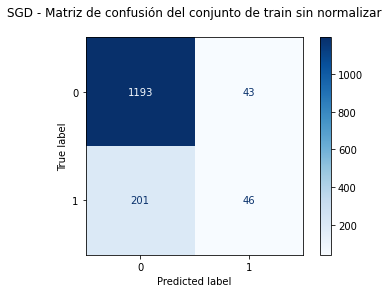

<Figure size 432x288 with 0 Axes>

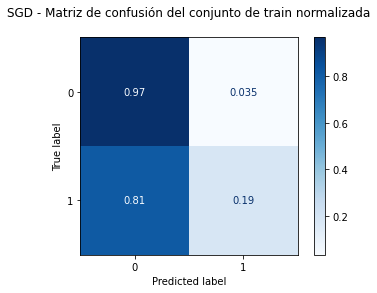

In [17]:
# Matriz de confusión del conjunto de train
plt.figure()
plot_confusion_matrix(estimator=sgd, X=X_train, y_true=y_train,
                      normalize=None, cmap='Blues', values_format='d').ax_.set_title('SGD - Matriz de confusión del conjunto de train sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=sgd, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_.set_title('SGD - Matriz de confusión del conjunto de train normalizada\n');

<Figure size 432x288 with 0 Axes>

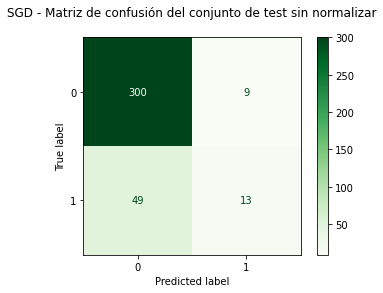

<Figure size 432x288 with 0 Axes>

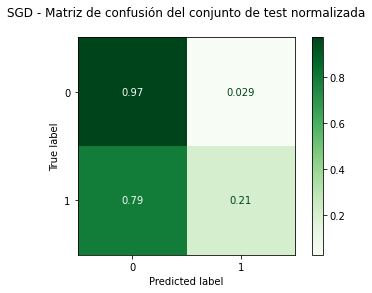

In [18]:
# Matriz de confusión del conjunto de test
plt.figure()
plot_confusion_matrix(estimator=sgd, X=X_test, y_true=y_test,
                      normalize=None, cmap='Greens', values_format='d').ax_.set_title('SGD - Matriz de confusión del conjunto de test sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=sgd, X=X_test, y_true=y_test,
                      normalize='true', cmap='Greens').ax_.set_title('SGD - Matriz de confusión del conjunto de test normalizada\n');

#### Conclusiones

- Podemos observar un valor de accuracy relativamente alto en el conjunto de test. Sin embargo, al encontrarse las clases desbalanceadas, **el accuracy no resulta una buena métrica para la predicción**.
- **Este desbalanceo de clases se puede apreciar en las métricas F1-score**. Para la clase con mayor cantidad de casos (0), el valor obtenido es alto (\~0.3). Mientras que para la clase con menos valores (1), el resultado es bastante bajo (\~0.5).
- Para una clasificación ideal, **los valores más altos de la matriz de confusión deben estar posicionados en la diagonal principal de ésta**. Esto claramente no sucede para las predicciones en el conjunto de test debido al desbalanceo.

Según el objetivo final de la predicción, pueden resultar útiles las métricas de recall y de precisión. 

- ¿Cuántas personas morosas somos capaces de identificar? El recall resulta una métrica interesante para responder esta pregunta. En este caso, tenemos un valor bastante bajo (0.21), es decir que sólo identificaremos de forma correcta aproximadamente al 21% de los efectivamente morosos.
- Si el objetivo final es ofrecer préstamos solamente a personas que cumplirían con su pago (clase 0), la precisión es una buena métrica a observar. En este caso, vemos una precisión relativamente alta (0.86), es decir, de todas las veces que el modelo dijo que el cliente pagaría el préstamo, realmente lo pagó un 86%.

 

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Realizamos grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento, con diferentes combinaciones de hiperparámetros:

In [19]:
fold_sgd = 5 # 5-fold cross-validation

param_grid = {
    "loss" : ['hinge', 'modified_huber', 'squared_hinge'],
    "penalty" : ["l2", "l1", "elasticnet"], # tasa de regularización
    "eta0" : [1, 10, 100],
    "learning_rate" : ['constant', 'optimal', 'adaptive'], # tasa de entrenamiento
}

sgd_cv = SGDClassifier(random_state=0)

cv_sgd = GridSearchCV(sgd_cv, param_grid, scoring='accuracy', cv=fold_sgd)
cv_sgd.fit(X_train, y_train);

Guardamos los resultados para poder visualizar el accuracy promedio y varianza para todas las configuraciones:

In [20]:
results = cv_sgd.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

In [21]:
df = pd.DataFrame(results)
df[['param_loss', 'param_penalty', 'param_eta0', 'param_learning_rate', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_loss,param_penalty,param_eta0,param_learning_rate,mean_test_score,std_test_score,rank_test_score
0,hinge,l2,1,constant,0.836107,0.024160,40
1,hinge,l1,1,constant,0.844228,0.014438,33
2,hinge,elasticnet,1,constant,0.839528,0.017276,34
3,modified_huber,l2,1,constant,0.817297,0.037251,56
4,modified_huber,l1,1,constant,0.850309,0.010264,31
...,...,...,...,...,...,...,...
76,modified_huber,l1,100,adaptive,0.867845,0.010852,10
77,modified_huber,elasticnet,100,adaptive,0.866494,0.010058,17
78,squared_hinge,l2,100,adaptive,0.865818,0.010692,22
79,squared_hinge,l1,100,adaptive,0.866491,0.010954,21


Listamos como referencia los parámetros por defecto del modelo SGD sin CV:
```
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
```



Guardamos el mejor modelo obtenido de la Optimización de Hiperparámetros: 

In [22]:
best_model = cv_sgd.best_estimator_

Mejores parámetros elegidos de todas las combinaciones de la Optimización de Hiperparámetros con SGSClassifier:

In [23]:
cv_sgd.best_params_

{'eta0': 1, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'l2'}

Predecimos con el mejor modelo obtenido en la optimización de hiperparámetros:

In [24]:
# Predecir
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [25]:
# Valores únicos en la predicción de train
np.unique(y_train_pred)

array([0, 1])

In [26]:
# Valores únicos en la predicción de test
np.unique(y_test_pred)

array([0, 1])

Reportamos las métricas del mejor modelo obtenido en la optimización de hiperparámetros:

In [27]:
# Evaluar train
print("===========================================================")
print("SGD con CV - Reporte de clasificación del conjunto de train")
print("===========================================================\n")
print(classification_report(y_train, y_train_pred))

SGD con CV - Reporte de clasificación del conjunto de train

              precision    recall  f1-score   support

           0       0.87      0.99      0.93      1236
           1       0.90      0.26      0.41       247

    accuracy                           0.87      1483
   macro avg       0.89      0.63      0.67      1483
weighted avg       0.88      0.87      0.84      1483



In [28]:
# Evaluar test
print("==========================================================")
print("SGD con CV - Reporte de clasificación del conjunto de test")
print("==========================================================\n")
print(classification_report(y_test, y_test_pred))

SGD con CV - Reporte de clasificación del conjunto de test

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       309
           1       1.00      0.29      0.45        62

    accuracy                           0.88       371
   macro avg       0.94      0.65      0.69       371
weighted avg       0.90      0.88      0.85       371



<Figure size 432x288 with 0 Axes>

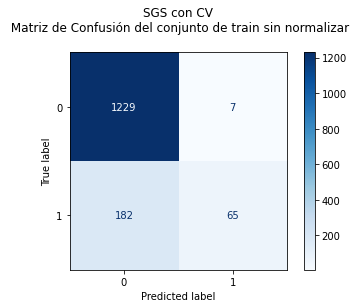

<Figure size 432x288 with 0 Axes>

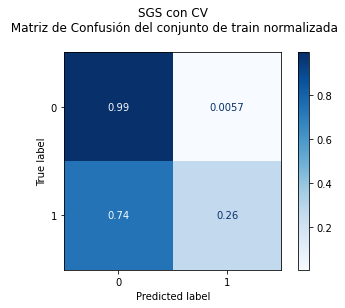

In [29]:
# Matriz de confusión del conjunto de train
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_train, y_true=y_train,
                      normalize=None, cmap='Blues', values_format='d').ax_.set_title('SGS con CV\n Matriz de Confusión del conjunto de train sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_.set_title('SGS con CV\n Matriz de Confusión del conjunto de train normalizada\n');

<Figure size 432x288 with 0 Axes>

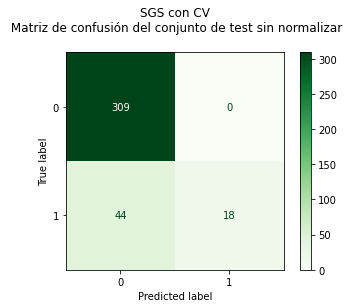

<Figure size 432x288 with 0 Axes>

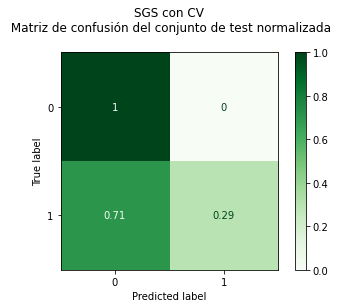

In [30]:
# Matriz de confusión del conjunto de test
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_test, y_true=y_test,
                      normalize=None, cmap='Greens', values_format='d').ax_.set_title('SGS con CV\n Matriz de confusión del conjunto de test sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_test, y_true=y_test,
                      normalize='true', cmap='Greens').ax_.set_title('SGS con CV\n Matriz de confusión del conjunto de test normalizada\n');

Se verifica que el modelo obtenido con la optimización de hiperparámetros:

```
{'eta0': 1, 'learning_rate': 'adaptive', 'loss': 'hinge', 'penalty': 'l2'}
```

resulta mejor que el modelo con parámetros por defecto:

- El accuracy en test pasó de 0.84 a 0.88.
- El F1-Score de la clase 1 pasó de 0.31 a 0.45. Y para la clase 0, mejoró de 0.91 a 0.93.
- Reflexiones: 
  - Notamos una precisión alta en ambas clases, esto significa que lo que predice el modelo, lo predice bien. Sin embargo, vemos un valor bajo de recall para la clase 1, lo cual indica que hay observaciones con etiqueta 1 que no fueron predichas como tal por el modelo (quedaron afuera).
  - Pensamos que dada la poca cantidad de datos, o la complejidad de la clasificación, se vuelve difícil predecir la etiqueta con los modelos probados. El pago de una deuda puede estar condicionado por variables que no están representadas por estos features, y esto puede estar reflejándose en las métricas. Para mejorarlas, pensamos que se puede incrementar la muestra, trabajar con técnicas de desbalanceo o quizás replantear la pregunta que se quiere responder, para reducir la complejidad del modelo.






## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión


In [31]:
# Instanciar y entrenar.
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [32]:
dtree.get_depth()

20

In [33]:
# Predecir
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)

In [34]:
# Valores únicos en la predicción de train
np.unique(y_train_pred)

array([0, 1])

En el conjunto de train el modelo DecisionTreeClassifier está prediciendo tanto valores 0, como valores 1.

In [35]:
# Valores únicos en la predicción de test
np.unique(y_test_pred)

array([0, 1])

En el conjunto de test el modelo DecisionTreeClassifier está prediciendo tanto valores 0 como valores 1.

Reportamos las métricas obtenidas por el modelo DesicionTreeClassifier con los parámetros por defecto:

In [36]:
# Evaluar train
print("==============================================================")
print("Decision Tree - Reporte de clasificación del conjunto de train")
print("==============================================================\n")
print(classification_report(y_train, y_train_pred))

Decision Tree - Reporte de clasificación del conjunto de train

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1236
           1       1.00      1.00      1.00       247

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483



In [37]:
# Evaluar test
print("=============================================================")
print("Decision Tree - Reporte de clasificación del conjunto de test")
print("=============================================================\n")
print(classification_report(y_test, y_test_pred))

Decision Tree - Reporte de clasificación del conjunto de test

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       309
           1       0.67      0.58      0.62        62

    accuracy                           0.88       371
   macro avg       0.79      0.76      0.78       371
weighted avg       0.88      0.88      0.88       371



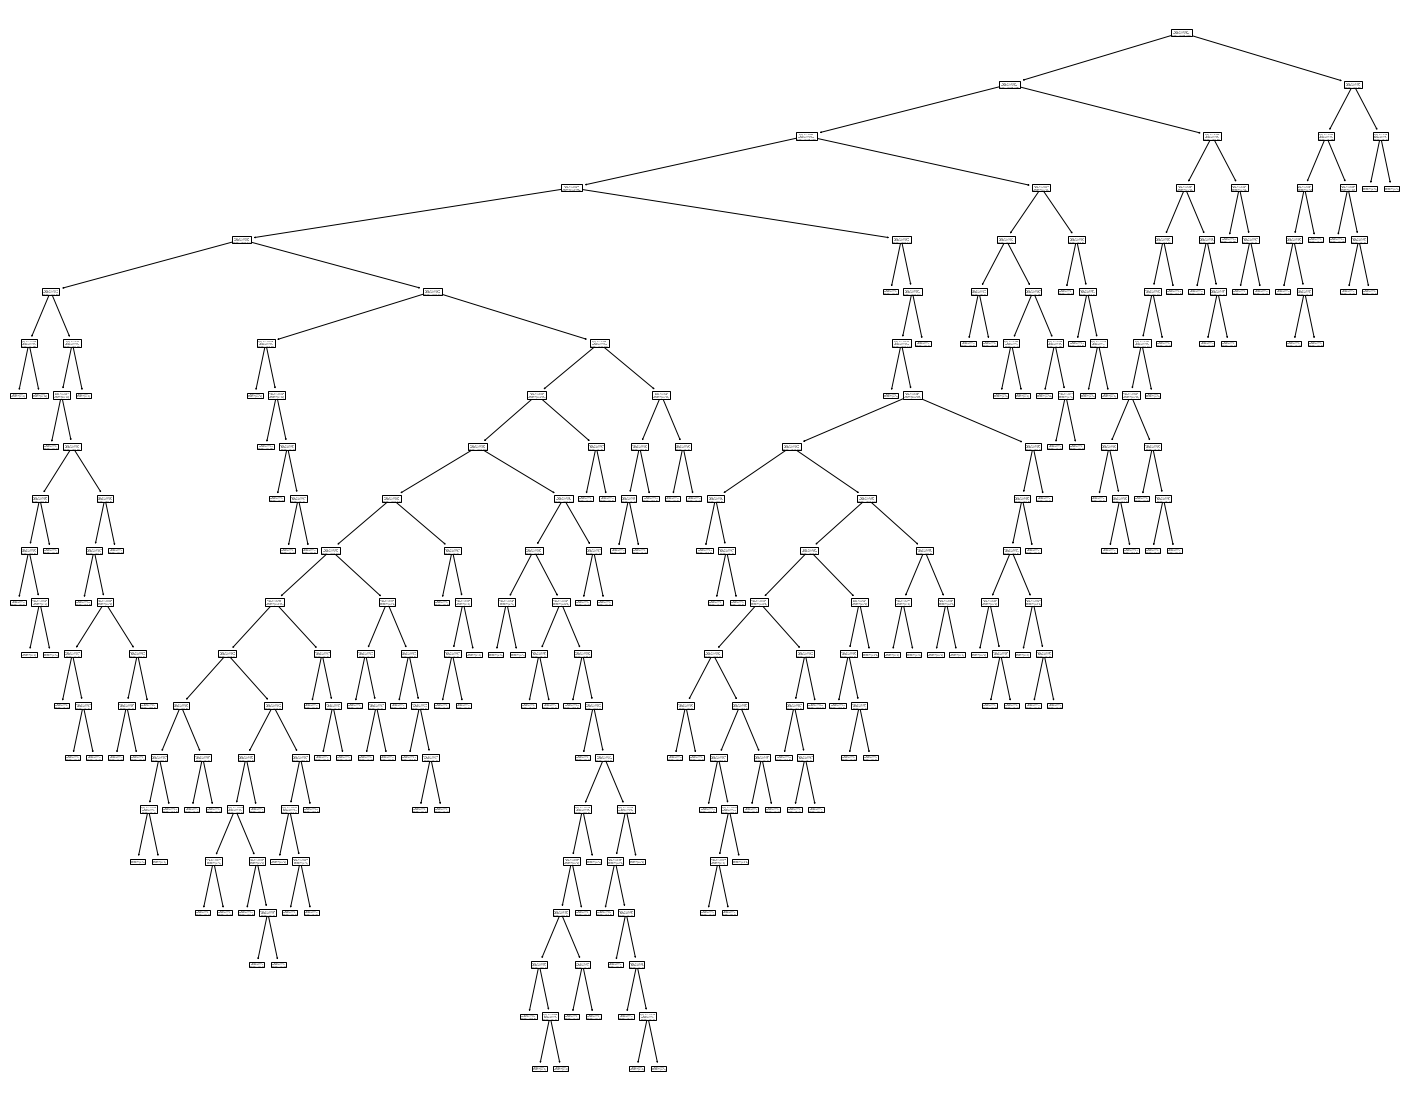

In [38]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dtree);

<Figure size 432x288 with 0 Axes>

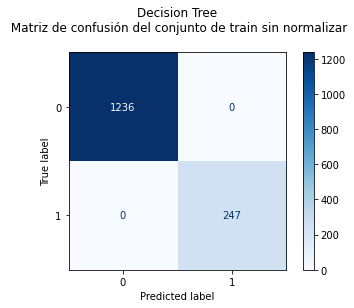

<Figure size 432x288 with 0 Axes>

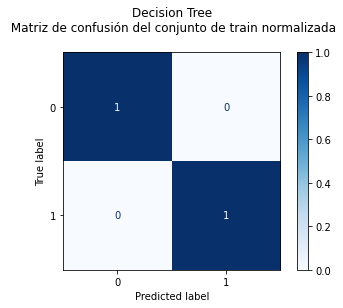

In [39]:
# Matriz de confusión del conjunto de train
plt.figure()
plot_confusion_matrix(estimator=dtree, X=X_train, y_true=y_train,
                      normalize=None, cmap='Blues', values_format='d').ax_.set_title('Decision Tree\n Matriz de confusión del conjunto de train sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=dtree, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_.set_title('Decision Tree\n Matriz de confusión del conjunto de train normalizada\n');

<Figure size 432x288 with 0 Axes>

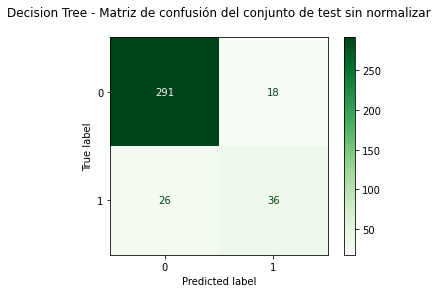

<Figure size 432x288 with 0 Axes>

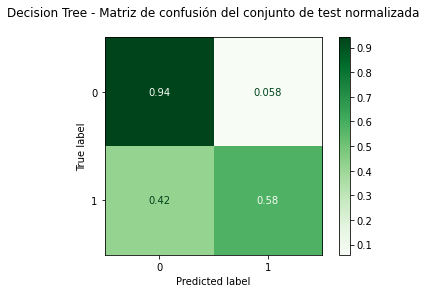

In [40]:
# Matriz de confusión del conjunto de test
plt.figure()
plot_confusion_matrix(estimator=dtree, X=X_test, y_true=y_test,
                      normalize=None, cmap='Greens', values_format='d').ax_.set_title('Decision Tree - Matriz de confusión del conjunto de test sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=dtree, X=X_test, y_true=y_test,
                      normalize='true', cmap='Greens').ax_.set_title('Decision Tree - Matriz de confusión del conjunto de test normalizada\n');

Conclusiones:
- Vemos que el modelo Decision Tree con los parámetros por defecto, sobreajusta en el conjunto de train. Esto se observa en que las métricas son todas 1 y que el árbol tiene muchos niveles de profundidad. 
- Sin embargo, las métricas obtenidas en el conjunto de test son buenas y mejoran con respecto a las obtenidas en el modelo SGD: el F1-Score de test pasó de 0.45 a 0.62 para la clase 1.

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Realizamos grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento, con diferentes combinaciones de hiperparámetros:

In [41]:
fold_dtree = 5 # 5-fold cross-validation

param_grid = {
    "criterion" : ['gini','entropy'],
    "max_depth" : [2,4,6,8,10,12,14,16],
    "min_samples_leaf" : [1,2,3,4,6],
    'max_leaf_nodes': [5,10,15,20,25,30],
}

dtree_cv = DecisionTreeClassifier(random_state=0)

cv_dtree = GridSearchCV(dtree_cv, param_grid, scoring='accuracy', cv=fold_dtree)
cv_dtree.fit(X_train, y_train);

Guardamos los resultados para poder visualizar el accuracy promedio y varianza para todas las configuraciones:

In [42]:
results = cv_dtree.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

In [43]:
df = pd.DataFrame(results)
df[['param_criterion', 'param_max_depth', 'param_min_samples_leaf', 'param_max_leaf_nodes', 'mean_test_score', 'std_test_score', 'rank_test_score']] 

,param_criterion,param_max_depth,param_min_samples_leaf,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,gini,2,1,5,0.867160,0.015184,321
1,gini,2,2,5,0.867160,0.015184,321
2,gini,2,3,5,0.867160,0.015184,321
3,gini,2,4,5,0.867160,0.015184,321
4,gini,2,6,5,0.867160,0.015184,321
...,...,...,...,...,...,...,...
475,entropy,16,1,30,0.877284,0.015244,65
476,entropy,16,2,30,0.875933,0.014781,109
477,entropy,16,3,30,0.876599,0.017407,92
478,entropy,16,4,30,0.872552,0.022118,232


Listamos como referencia los parámetros por defecto del modelo Decision Tree sin CV:



```
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
```



Guardamos el mejor modelo obtenido de la Optimización de Hiperparámetros:

In [44]:
best_model = cv_dtree.best_estimator_

Mejores parámetros elegidos de todas las combinaciones de la Optimización de Hiperparámetros con Decision Tree Classifier:

In [45]:
cv_dtree.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 3}

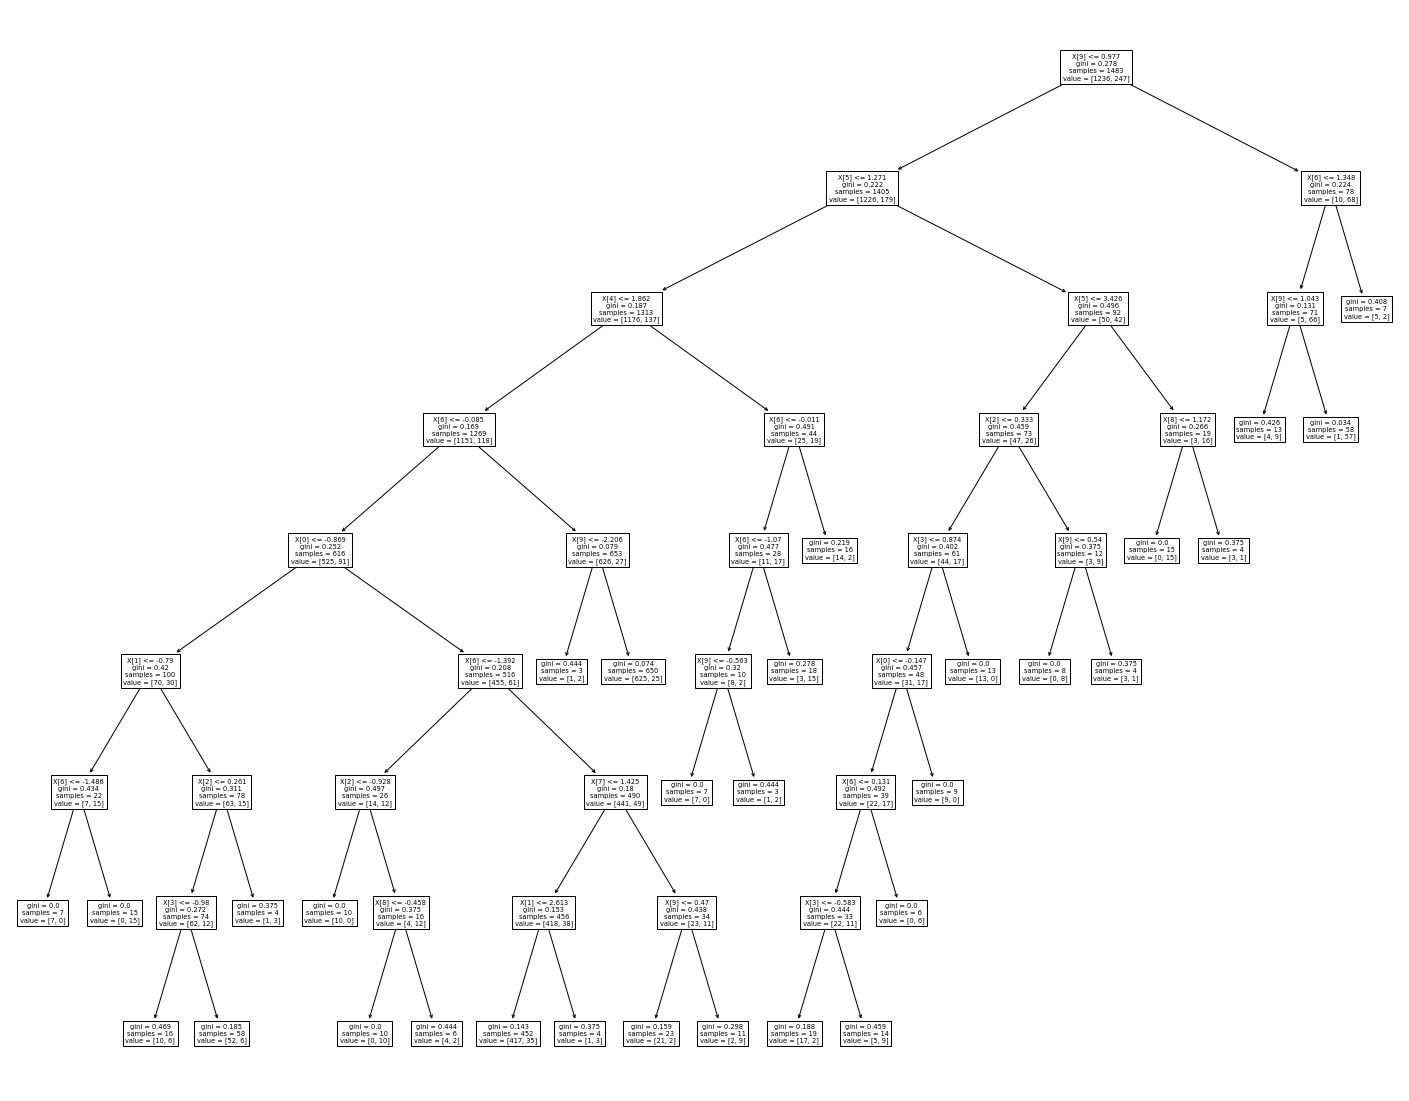

In [46]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(best_model);

Predecimos con el mejor modelo obtenido en la optimización de hiperparámetros:

In [47]:
# Predecir
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [48]:
# Valores únicos en la predicción de train
np.unique(y_train_pred)

array([0, 1])

In [49]:
# Valores únicos en la predicción de test
np.unique(y_test_pred)

array([0, 1])

Reportamos las métricas del mejor modelo obtenido en la optimización de hiperparámetros:

In [50]:
# Evaluar train
print("=====================================================================")
print("Decision Tree con CV - Reporte de clasificación del conjunto de train")
print("=====================================================================\n")
print(classification_report(y_train, y_train_pred))

Decision Tree con CV - Reporte de clasificación del conjunto de train

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1236
           1       0.90      0.66      0.76       247

    accuracy                           0.93      1483
   macro avg       0.92      0.82      0.86      1483
weighted avg       0.93      0.93      0.93      1483



In [51]:
# Evaluar test
print("====================================================================")
print("Decision Tree con CV - Reporte de clasificación del conjunto de test")
print("====================================================================\n")
print(classification_report(y_test, y_test_pred))

Decision Tree con CV - Reporte de clasificación del conjunto de test

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       309
           1       0.77      0.53      0.63        62

    accuracy                           0.89       371
   macro avg       0.84      0.75      0.78       371
weighted avg       0.89      0.89      0.89       371



<Figure size 432x288 with 0 Axes>

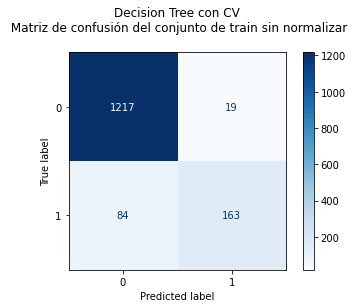

<Figure size 432x288 with 0 Axes>

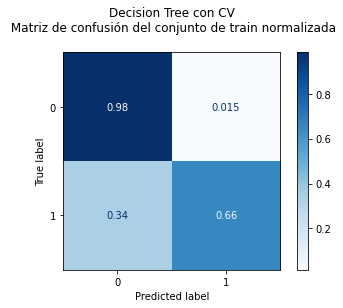

In [52]:
# Matriz de correlación del conjunto de train
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_train, y_true=y_train,
                      normalize=None, cmap='Blues', values_format='d').ax_.set_title('Decision Tree con CV\n Matriz de confusión del conjunto de train sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_train, y_true=y_train,
                      normalize='true', cmap='Blues').ax_.set_title('Decision Tree con CV\n Matriz de confusión del conjunto de train normalizada\n');
                      

<Figure size 432x288 with 0 Axes>

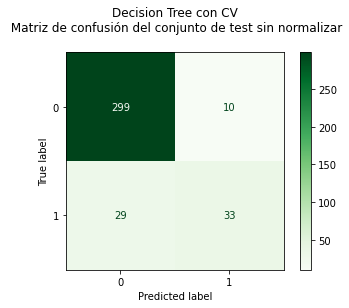

<Figure size 432x288 with 0 Axes>

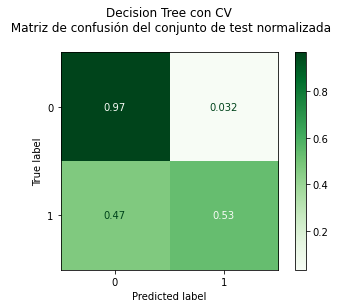

In [53]:
# Matriz de confusión del conjunto de test
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_test, y_true=y_test,
                      normalize=None, cmap='Greens', values_format='d').ax_.set_title('Decision Tree con CV\n Matriz de confusión del conjunto de test sin normalizar\n')
plt.figure()
plot_confusion_matrix(estimator=best_model, X=X_test, y_true=y_test,
                      normalize='true', cmap='Greens').ax_.set_title('Decision Tree con CV\n Matriz de confusión del conjunto de test normalizada\n');

Conclusiones:
- Con el ajuste de hiperparámetros, se obtiene un accuracy y F1-Score parecidos en train y test, por lo tanto no hay sobreajuste.
- Por otro lado al comparar las métricas con el modelo que utiliza los parámetros por defecto, vemos que no hay mejoras significativas: el accuracy pasó de 0.88 a 0.89 y el F1-Score para la clase 0 pasó de 0.93 a 0.94 y para la clase 1 de 0.62 a 0.63. (Y representa mejoras significativas con respecto al modelo SGD).
- Sin embargo, el modelo con optimización de parámetros utiliza una menor cantidad de niveles de profundidad (8 en lugar de 20), obteniendo métricas similares, por lo que nos quedaríamos con el modelo optimizado.